[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/23_likelihood_function_and_dummy_coding.ipynb)

The code so far:

In [1]:
# uncomment the lines below to install the correct version of pymc3 and dependencies
# !pip3 install --upgrade 'arviz==0.11.1'
# !pip3 install --upgrade 'pymc3==3.9.3'

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import pandas as pd
import pymc3 as pm

In [3]:
url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/every_each.csv?raw=true'
every_each = pd.read_csv(url)
every_each["quant"] = every_each["quant"].astype('category')
every_each.shape

(347, 2)

In [4]:
every_each.head(n=3)

,logRTresid,quant
0,0.056128,each
1,0.241384,each
2,0.056128,every


In [5]:
every_each.iloc[[0, 8, 18, 31], :]

,logRTresid,quant
0,0.056128,each
8,0.869077,every
18,-0.073706,every
31,-0.187536,each


In [6]:
np.min(every_each["logRTresid"]), np.max(every_each["logRTresid"])

(-0.678407840683957, 1.19278354190761)

In [7]:
every_each_model = pm.Model()

with every_each_model:
    normal_density = pm.Normal('normal_density', mu=0, sd=10)

In [8]:
from pymc3.backends import Text
from pymc3.backends.text import load

with every_each_model:
    db = Text('./data/normal_trace')
    trace = pm.sample(draws=5000, tune=500, cores=4, trace=db)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal_density]


Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 2 seconds.


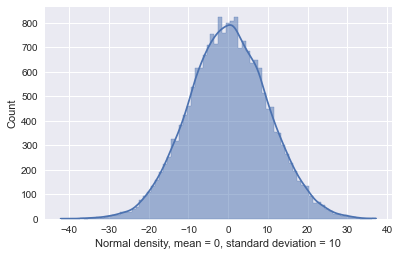

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3.5)
sns.histplot(trace['normal_density'], element='step',
             kde=True, ax=ax)
ax.set_xlabel('Normal density, mean = 0, standard deviation = 10')
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

## Our model for generating the data (the likelihood)

Now that we specified our priors, we can go ahead and specify the model for how (we think) nature generated the data.

- we need to mathematically specify how RT is a function of quantifier

Recall that we have about $170$ observations for each quantifier:

In [10]:
every_each["quant"].value_counts()

each     174
every    173
Name: quant, dtype: int64

What we conjecture as our model for the data, a.k.a. our _likelihood_ function, is that we have two mean RTs for the two quantifiers _every_ and _each_.

- for each of the two quantifiers, the RTs we observed are imperfect reflections of the mean RT for that quantifier
    - they are somewhere around the mean for that quantifier
- specifically, the observed RTs for a quantifier are composed of the mean RT for that quantifier + some error
    - the error is due to our imperfect measurement, natural variability in the data source (e.g., a participant was faster pressing the space bar on one occasion than another) etc.

Plotting the RTs by quantifier will make this clearer:

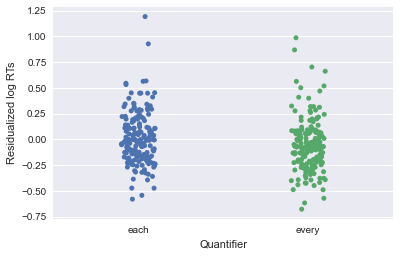

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3.5)
g = sns.stripplot(x="quant", y="logRTresid", data=every_each,
                  jitter=True)
g.set_xlabel("Quantifier")
g.set_ylabel("Residualized log RTs")
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

The plot shos that:

- the 170+ observations collected for _each_ are centered somewhere around $0.05$ ms
- the 170+ observations collected for _every_ are centered a little lower, around $-0.05$ ms

The observations are jittered (```jitter=True``` on line 4 above):

- they are not plotted on a straight line, so that we can distinguish overlapping points in the plot

Our likelihood function is as follows:

- the observations for _each_ are generated from the mean RT for _each_ (which is, say, around $0.05$) plus some error / noise around that mean RT
    - the noise is pretty substantial, with observed RTs spread between about $-0.75$ and $0.75$
- similarly, the observations for _every_ are generated from the mean RT for _every_ (which seems to be around $-0.05$ ms) plus some error / noise around that mean RT
    - once again, the noise is substantial, spreading the observed values mostly between $-0.75$ and $0.75$.

Our job right now is to write this story up in a single formula that will describe how the 347 RTs depend on quantifier.

Furthermore, recall that we are interested in the _difference_ between the two quantifiers:

- we want to estimate it so that we can determine whether this difference is likely different from $0$, i.e., whether the mean RT for _each_ is different from the mean RT for _every_, as Tunstall's differentiation condition would predict

To this end, we will estimate two quantities:

- the mean RT for _every_: $\textit{RT}_{\textit{every}}$
- the mean difference in RT between _each_ and _every_: $\textit{RT}_{\textit{each}-\textit{every}}$

With these two quantities in hand, we can obtain the mean RT for _each_ by summing them:

- $\textit{RT}_{\textit{each}} = \textit{RT}_{\textit{every}} + \textit{RT}_{\textit{each}-\textit{every}}$

We will now use a simple reformulation of the _quant_ variable (called `dummy coding' of the categorical predictor variable ```every_each["quant"]```) to be able to write a _single_ formula describing how all 347 RTs are a function of the quantifier they are associated with.

- we'll rewrite the _quant_ variable as taking either a value of $0$ or a value of $1$, depending on whether the RTs are associated with _every_ or _each_
- we then multiply this rewritten / dummy-coded _quant_ variable with the $\textit{RTs}_{\textit{each}-\textit{every}}$ difference

**Formula for RT as a function of quantifier**:

$\boxed{\textit{RT} = \textit{RT}_{\textit{every}} + \textit{quant} \cdot \textit{RT}_{\textit{each}-\textit{every}} + \textit{noise}}$

- if _RT_ is associated _every_, our dummy-coding for _quant_ says that $\textit{quant} = 0$
    - therefore, the _RT_ is generated from the mean RT for _every_ plus some noise
    - $\textit{RT} = \textit{RT}_{\textit{every}} + 0 \cdot \textit{RT}_{\textit{each}-\textit{every}} + \textit{noise} = \textit{RT}_{\textit{every}} + \textit{noise}$
- if _RT_ is associated with _each_, our dummy-coding for _quant_ says that $\textit{quant} = 1$
    - therefore, the _RT_ is generated from the mean RT for _each_ plus some noise
    - $\textit{RT} = \textit{RT}_{\textit{every}} + 1 \cdot \textit{RT}_{\textit{each}-\textit{every}} + \textit{noise} = \textit{RT}_{\textit{each}} + \textit{noise}$

The code for the dummy coding of the _quant_ variable is a one-liner (line 1 below)

- this takes advantage of the vectorial nature of both data and operations in ```numpy``` / ```pandas```
- the resulting ```"dummy_quant"``` variable recodes _each_ as 1 and _every_ as 0, as expected

In [12]:
every_each["dummy_quant"] = (every_each["quant"]=="each").astype("int")

every_each.head(n=6)

,logRTresid,quant,dummy_quant
0,0.056128,each,1
1,0.241384,each,1
2,0.056128,every,0
3,0.037743,each,1
4,-0.208206,every,0
5,-0.113990,every,0


We can now use the variable ```every_each["dummy_quant"]``` and the model, a.k.a. likelihood function above, to generate synthetic datasets.

- below, we set our mean RT for _every_ to $-0.05$ and our mean difference in RT to $0.1$ (lines 1-2)
- this will result in a mean RT of $0.05$ for _each_
- for convenience, we extract the dummy-coded ```dummy_quant``` variable and store it separately (line 3)
- we then assemble the means for the 347 synthetic observations we want to generate:
    - line 5 directly implements the likelihood function
- we can then look at the first 15 means thus assembled

In [13]:
mean_every = -0.05
mean_difference = 0.1
quant = np.array(every_each["dummy_quant"])

synthetic_RT_means = mean_every + quant * mean_difference
synthetic_RT_means[:15]

array([ 0.05,  0.05, -0.05,  0.05, -0.05, -0.05,  0.05,  0.05, -0.05,
        0.05, -0.05,  0.05,  0.05, -0.05, -0.05])

Note how the means match the quantifier:

- the first two are mean RTs associated with _each_, since the first two observations in our original data set are associated with _each_
    - their mean RT is therefore $0.05$

- the third observation is associated with _every_ since the third observation in our original data set was associated with _every_
     - its mean RT is therefore $-0.05$

- and so on

In [14]:
every_each.head(n=15)

,logRTresid,quant,dummy_quant
0,0.056128,each,1
1,0.241384,each,1
2,0.056128,every,0
3,0.037743,each,1
4,-0.208206,every,0
5,-0.113990,every,0
6,-0.041183,each,1
7,0.019087,each,1
8,0.869077,every,0
9,0.040079,each,1


The likelihood function has one final component: the noise.

- RTs from a specific quantifier are only imperfect, noisy reflections of the mean RT for that quantifier
- the noise comes from variations in the measuring equipment (keyboard etc.), or variations in the way the participants press the space bar at different times, or any other factor that we are not controlling for
- we generate noisy observations by drawing random numbers from a normal distribution: we use the ```numpy``` function ```random.normal``` for this purpose (line 2 below)
- the mean of the normal distribution is the mean RT for one quantifier or the other, and the standard deviation is set to $0.25$, which generates noise of about $+/- 0.75$
- the resulting RTs are randomly generated real numbers

In [15]:
sigma = 0.25
synthetic_RTs = np.random.normal(synthetic_RT_means, sigma)
synthetic_RTs.round(2)[:25]

array([ 0.21,  0.3 , -0.43, -0.18,  0.09,  0.39, -0.28,  0.04,  0.26,
        0.08,  0.1 ,  0.29,  0.05,  0.06, -0.26,  0.04,  0.32, -0.15,
        0.41,  0.03,  0.5 ,  0.07, -0.35,  0.1 ,  0.15])

We can compare these synthetic RTs to the actual RTs:

- we extract and store them in an independent variable ```RTs``` (line 2 below)
- we see that the range of variation in the synthetic data is pretty similar to the actual data

In [16]:
# compare to the actual RTs in our dataset
RTs = np.array(every_each["logRTresid"])
RTs.round(2)[:25]

array([ 0.06,  0.24,  0.06,  0.04, -0.21, -0.11, -0.04,  0.02,  0.87,
        0.04,  0.09, -0.02,  0.18, -0.49, -0.04,  0.17, -0.28, -0.16,
       -0.07, -0.18, -0.13, -0.27,  0.14, -0.34,  0.08])

Finally, if we want to synthesize more RT datasets that are similar to our actual dataset, we can simply do another set of draws from a normal distribution:

- centered at $-0.05$ or $0.05$ (depending on the quantifier)
- with a standard deviation of $0.25$

In [17]:
# repeat to generate a different sample of synthetic RTs
synthetic_RTs = np.random.normal(synthetic_RT_means, sigma)
synthetic_RTs.round(2)[:25]

array([-0.35,  0.31, -0.17, -0.16, -0.27,  0.35,  0.1 ,  0.42, -0.  ,
        0.07, -0.46,  0.26, -0.28,  0.29,  0.03,  0.09, -0.5 ,  0.15,
        0.04, -0.38, -0.16, -0.05,  0.03,  0.25, -0.4 ])